In [196]:
import os
import sys
sys.path.insert(0, os.path.abspath('../novelgraphs/'))

import novelgraphs as ng

import pandas as pd
from collections import defaultdict, Counter
from itertools import combinations
import networkx as nx
from operator import itemgetter
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from numpy import array_split
import numpy

In [2]:
# text = pd.read_pickle('fight_text.pickle')
text = pd.read_pickle('table.pickle')

In [3]:
text.tags.head()

,SentenceID,TokenID,Token,Lemma,Pos,NER,DepParse,DepRel,NerNpID,Sentiment,QuotationID,DialogID,CharacterID
0,0,0,A,a,DT,O,1,det,None,NaN,None,None,None
1,0,1,STUDY,study,NN,O,-1,ROOT,None,NaN,None,None,None
2,0,2,IN,in,IN,O,4,case,None,NaN,None,None,None
3,0,3,SCARLET,scarlet,NNP,O,4,compound,None,NaN,None,None,None
4,0,4,Table,table,NNP,O,1,nmod:in,None,NaN,None,None,None


In [4]:
core = ng.annotators.CoreNLP()
np = ng.annotators.NerNpID()
ann = ng.annotators.Sentiment()
ann2 = ng.annotators.Dialog()
qq = ng.annotators.Quote()
fp = ng.annotators.FirstPerson()
char = ng.annotators.Character()

In [325]:
pipeline = ng.annotators.Pipeline([ann, qq, ann2, fp, char])
pipeline.annotate(text)

In [5]:
dialog = ng.interaction.extractors.Dialog()
sentences = ng.interaction.extractors.Sentences()
sent_dist = ng.interaction.extractors.SentenceDistance()
tokens = ng.interaction.extractors.TokenDistance()
seq = ng.interaction.extractors.TokenSequence()
dep = ng.interaction.extractors.TokenDependencies()

count = ng.interaction.aggregators.Count()
sentiment = ng.interaction.aggregators.Sentiment()

In [136]:
novelgraph = ng.NovelGraph(tokens, sentiment)
graph = novelgraph(text)

In [137]:
def graph_weights(graph):
    return [edge[2]['weight'] for edge in graph.edges(data=True)]

weights = graph_weights(graph)

# plt.figure(figsize=(10,10))
# plt.axis('off')
# nx.draw_networkx(graph,
#                  with_labels=True,
#                  edge_color=weights,
#                  edge_cmap=plt.cm.coolwarm,
#                  edge_vmax = 0.5, edge_vmin=-0.5, alpha=0.6)

### Rolling window

In [85]:
def rolling_window_slices(window_size, step, length):
    if length <= 18000:
        window_size = 3000
        step = 1000
    
    num_slices = max((length - window_size) // step, 0)
    return ([slice(i * step, i * step + window_size) for i in range(num_slices)] +
             [slice(num_slices * step, length)])

In [202]:
rolling_window_slices(10000, 2000, len(text.tags))[:5]

[slice(0, 10000, None),
 slice(2000, 12000, None),
 slice(4000, 14000, None),
 slice(6000, 16000, None),
 slice(8000, 18000, None)]

### Negative graph plot

In [87]:
# num_chapters = 10

# chapters = []
# for tags in array_split(text.tags, num_chapters):
#     chapter = ng.Text('')
#     chapter.characters = text.characters
#     chapter.first_person = text.first_person
#     chapter.tags = tags
#     chapters.append(chapter)

In [88]:
chapters = []
for slice_t in rolling_window_slices(5000, 2000, len(text.tags)):
    tags = text.tags.loc[slice_t]
    chapter = ng.Text('')
    chapter.characters = text.characters
    chapter.first_person = text.first_person
    chapter.tags = tags
    chapters.append(chapter)

In [89]:
text_balance = []
for i in range(len(chapters)):
    graph = novelgraph(chapters[i])
    weights = graph_weights(graph)
    if weights:
        balance = len([p for p in weights if p < 0]) / len(weights)
        text_balance.append(balance)
#     else:
#         print('No weights')

In [201]:
# text_balance

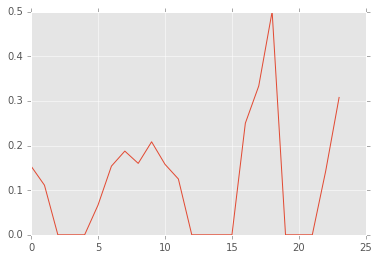

In [91]:
plt.plot(text_balance)

- Мера сбалансированности: отношение значений < 0 ко всем значениям => чем ближе к 1, тем несбалансированней, чем ближе к 0 - тем ближе к балансу
    - tokens
    - sentences
    
- Seq и Dep могут оказаться пустыми!
    - seq периодически вылетает с ошибкой (добавить проверку i + 2 < len(text))
- количество "глав" должно быть разным для разных произведений (например, для коротких - 5, для длинных - больше)
- 10 хорошее количество глав, но лучше двигаться скользящим окном
- вопрос с nan

### Balanced graph plot

In [198]:
senti = []
weights_sign = []
balance_sign = []
balance_graph = []

for i in range(len(chapters)):
    graph = novelgraph(chapters[i])
    weights = graph_weights(graph)
#     print(nx.cycle_basis(graph))

    for i in range(len(nx.cycle_basis(graph))):
#         print(i)
        senti.append([nx.cycle_basis(graph)[i][0], nx.cycle_basis(graph)[i][-1]])
        for x in range(len(nx.cycle_basis(graph)[i])):
            if x+1 < len(nx.cycle_basis(graph)[i]):
                senti.append([nx.cycle_basis(graph)[i][x], nx.cycle_basis(graph)[i][x+1]])
#         print(senti)
        
        for i in range(len(senti)):
            for edge in graph.edges(data=True):
                if edge[0] == tuple(sorted(senti[i]))[0] and edge[1] == tuple(sorted(senti[i]))[1]:
                    weights_sign.append(edge[2]['weight'])
                    
        if len([i for i in weights_sign if i < 0]) % 2 == 1:
            balance_sign.append(0)
        else:
            balance_sign.append(1)
        
        balance_graph.append(numpy.mean([balance_sign]))

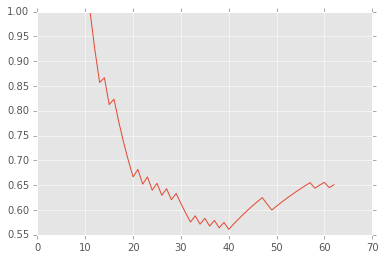

In [200]:
plt.plot(balance_graph)